# Space Weather Analysis

## Correlation between Solar Activity and Geomagnetic Storms


### Abstract

The notebook aims to analyze how solar flares and coronal mass ejections influence the occurrence and severity of geomagnetic storms. Data on solar flares (SF),  coronal mass ejections (CME), and geomagnetic storms (GST) were collected using NASA's Space Weather API from Jan 2021 to December 2023. The goal is to explore whether there is a correlation between solar flare intensity, CME speed, and the strength of geomagnetic storms. The analysis will involve correlation analysis, time series analysis, rolling averages, and cross-correlation between Solar FLare (SF), Coronal Mass Ejection (CME), and Geomagnetic Strom (GST) using NumPy, Pandas, and Matplotlib for visualization.

### Importing Relevant Libraries/ Modules

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import urllib.request

In [82]:
import os
API_KEY = os.getenv('NASA_API_KEY', 'DEMO_KEY')

### Solar Flare Data

**Fetching Solar Flare Data**

In [84]:
url_flare = f"https://api.nasa.gov/DONKI/FLR?startDate=2021-01-01&endDate=2023-12-31&api_key={API_KEY}"
result_flare = urllib.request.urlopen(url_flare)
text_flare = result_flare.read()
print(type(text_flare))
json_object_flare=json.loads(str(text_flare,"utf-8")) #Good practice
#print(json.dumps(json_object_flare,indent=5))

<class 'bytes'>


In [85]:
print(type(json_object_flare))

<class 'list'>


In [86]:
flare_df = pd.DataFrame(json_object_flare) 
flare_df.tail()

,flrID,catalog,instruments,beginTime,peakTime,endTime,classType,sourceLocation,activeRegionNum,note,submissionTime,versionId,link,linkedEvents
879,2023-12-24T11:09:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-12-24T11:09Z,2023-12-24T11:18Z,2023-12-24T11:24Z,M2.9,S20W25,13529.0,,2023-12-24T13:51Z,2,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,None
880,2023-12-24T16:37:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-12-24T16:37Z,2023-12-24T16:49Z,2023-12-24T16:56Z,M2.6,S20W30,13529.0,,2023-12-24T17:32Z,1,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,None
881,2023-12-24T19:21:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-12-24T19:21Z,2023-12-24T19:51Z,0023-12-24T20:16Z,M1.1,S23E90,NaN,This flare occurred from an unnumbered region ...,2023-12-24T21:24Z,1,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,[{'activityID': '2023-12-24T20:00:00-CME-001'}]
882,2023-12-31T18:44:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-12-31T18:44Z,2023-12-31T19:12Z,2023-12-31T19:40Z,M1.0,N04E80,13536.0,,2023-12-31T22:10Z,2,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,None
883,2023-12-31T21:40:00-FLR-001,M2M_CATALOG,[{'displayName': 'GOES-P: EXIS 1.0-8.0'}],2023-12-31T21:37Z,2023-12-31T21:55Z,2023-12-31T22:08Z,X5.0,N04E80,13536.0,,2023-12-31T22:17Z,7,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,[{'activityID': '2023-12-31T22:00:00-CME-001'}...


**Extract relevant columns and initial cleaning**

In [87]:
flare_df['beginTime'] = pd.to_datetime(flare_df['beginTime']) #Convert Date Columns to DateTime Format
flare_df = flare_df[['beginTime', 'classType']] #Relevant field EXTRACTION
flare_df.replace('..', np.nan, inplace=True)
flare_df.dropna() #Drop all rows with NaN values
flare_df.head()

,beginTime,classType
0,2021-02-26 07:01:00+00:00,B9.5
1,2021-03-09 12:17:00+00:00,C1.6
2,2021-04-17 16:20:00+00:00,B9.7
3,2021-04-19 23:19:00+00:00,M1.1
4,2021-04-22 04:10:00+00:00,C3.8


### Coronal Mass Ejection Data

**Fetching Coronal Mass Ejection Data**

In [88]:
url_cme = f"https://api.nasa.gov/DONKI/CMEAnalysis?startDate=2021-01-01&endDate=2023-12-31&mostAccurateOnly=true&speed=500&halfAngle=30&catalog=ALL&api_key={API_KEY}"
result_cme = urllib.request.urlopen(url_cme)
text_cme = result_cme.read()
json_object_cme=json.loads(str(text_cme,"utf-8"))
#print(json.dumps(json_object_cme,indent=5))

In [94]:
cme_df = pd.DataFrame(json_object_cme)
cme_df.head()

,time21_5,latitude,longitude,halfAngle,speed,type,isMostAccurate,associatedCMEID,note,catalog,featureCode,dataLevel,measurementTechnique,imageType,tilt,minorHalfWidth,speedMeasuredAtHeight,submissionTime,versionId,link
0,2021-01-02T16:52Z,-26.0,44.0,30.0,626.0,C,True,2021-01-02T11:24:00-CME-001,This CME analysis used STEREO A COR2 differenc...,M2M_CATALOG,null,1,SWPC_CAT,running difference,None,NaN,NaN,2021-01-05T16:35Z,2,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...
1,2021-01-06T12:33Z,15.0,44.0,31.0,529.0,C,True,2021-01-06T04:24:00-CME-001,These preliminary CME parameters were derived ...,M2M_CATALOG,null,0,SWPC_CAT,running difference,None,NaN,NaN,2021-01-06T21:22Z,2,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...
2,2021-02-20T18:33Z,-18.0,-31.0,50.0,680.0,C,True,2021-02-20T11:36:00-CME-001,,M2M_CATALOG,null,0,SWPC_CAT,running difference,None,NaN,NaN,2021-02-21T14:45Z,1,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...
3,2021-03-16T19:28Z,-10.0,165.0,31.0,514.0,C,True,2021-03-16T11:09:00-CME-001,Multiple SWPC_CAT measurements using different...,M2M_CATALOG,null,0,SWPC_CAT,running difference,None,NaN,NaN,2021-03-17T17:42Z,2,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...
4,2021-04-17T20:42Z,-8.0,-125.0,38.0,882.0,C,True,2021-04-17T16:36:00-CME-001,Remeasured shock front using STEREO A COR2 Sci...,M2M_CATALOG,SH,2,StereoCAT,direct,None,NaN,NaN,2021-04-21T21:34Z,1,https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...


**Extract relevant columns and initial cleaning**

In [96]:
cme_df['startTime'] = pd.to_datetime(cme_df['time21_5'])
cme_df = cme_df[['startTime', 'speed']]
cme_df.replace('..', np.nan, inplace=True)
cme_df.dropna() 
cme_df.head()

,startTime,speed
0,2021-01-02 16:52:00+00:00,626.0
1,2021-01-06 12:33:00+00:00,529.0
2,2021-02-20 18:33:00+00:00,680.0
3,2021-03-16 19:28:00+00:00,514.0
4,2021-04-17 20:42:00+00:00,882.0


### Geomagnetic Strom (GST) Data

**Fetching Geomagnetic Strom (GST) Data**

In [98]:
url_gst = f"https://api.nasa.gov/DONKI/GST?startDate=2021-01-01&endDate=2023-12-31&api_key={API_KEY}"
result_gst = urllib.request.urlopen(url_gst)
text_gst = result_gst.read()
json_object_gst=json.loads(str(text_gst,"utf-8"))
#print(json.dumps(json_object_gst,indent=5))

In [108]:
gst_df = pd.DataFrame(json_object_gst)
gst_df.head()

,gstID,startTime,allKpIndex,link,linkedEvents,submissionTime,versionId
0,2021-03-01T03:00:00-GST-001,2021-03-01T03:00Z,"[{'observedTime': '2021-03-01T06:00Z', 'kpInde...",https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,[{'activityID': '2021-02-28T21:41:00-HSS-001'}...,2021-03-01T06:35Z,1
1,2021-03-20T06:00:00-GST-001,2021-03-20T06:00Z,"[{'observedTime': '2021-03-20T09:00Z', 'kpInde...",https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,[{'activityID': '2021-03-19T19:00:00-HSS-001'}],2021-03-20T09:35Z,1
2,2021-05-12T12:00:00-GST-001,2021-05-12T12:00Z,"[{'observedTime': '2021-05-12T15:00Z', 'kpInde...",https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,[{'activityID': '2021-05-09T11:23:00-CME-001'}...,2021-05-12T15:41Z,1
3,2021-10-12T03:00:00-GST-001,2021-10-12T03:00Z,"[{'observedTime': '2021-10-12T06:00Z', 'kpInde...",https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,[{'activityID': '2021-10-09T07:09:00-CME-001'}],2021-10-12T06:36Z,1
4,2021-11-03T21:00:00-GST-001,2021-11-03T21:00Z,"[{'observedTime': '2021-11-04T00:00Z', 'kpInde...",https://webtools.ccmc.gsfc.nasa.gov/DONKI/view...,[{'activityID': '2021-11-01T18:38:00-CME-001'}...,2021-11-04T00:55Z,1


**Extract relevant columns and initial cleaning**

In [110]:
gst_df['startTime'] = pd.to_datetime(gst_df['startTime'])
gst_df = gst_df[["startTime","allKpIndex"]]
gst_df['kpIndex'] = gst_df['allKpIndex'].apply(lambda row: row[0]['kpIndex'] if row else None) 
gst_df=gst_df[['startTime','kpIndex']]
gst_df.replace('..', np.nan, inplace=True)
gst_df.dropna() 
gst_df.head()

,startTime,kpIndex
0,2021-03-01 03:00:00+00:00,6.0
1,2021-03-20 06:00:00+00:00,6.0
2,2021-05-12 12:00:00+00:00,7.0
3,2021-10-12 03:00:00+00:00,6.0
4,2021-11-03 21:00:00+00:00,7.0


### Combining Data Frames and More Cleaning

For merging data frame I have used "merge_asof" because I need to match rows by the nearest key value rather than equal keys

But lets first sort the data frames by the date columns

In [112]:
flare_df = flare_df.sort_values('beginTime')
cme_df = cme_df.sort_values('startTime')
gst_df=gst_df.sort_values("startTime")

**Merging Solar Flare and CME and GST data frames**

In [114]:
combined_df = pd.merge_asof(flare_df, cme_df, left_on='beginTime', right_on='startTime', direction='nearest')
combined_df

,beginTime,classType,startTime,speed
0,2021-02-26 07:01:00+00:00,B9.5,2021-02-20 18:33:00+00:00,680.0
1,2021-03-09 12:17:00+00:00,C1.6,2021-03-16 19:28:00+00:00,514.0
2,2021-04-17 16:20:00+00:00,B9.7,2021-04-17 20:42:00+00:00,882.0
3,2021-04-19 23:19:00+00:00,M1.1,2021-04-17 20:42:00+00:00,882.0
4,2021-04-22 04:10:00+00:00,C3.8,2021-04-22 09:37:00+00:00,803.0
...,...,...,...,...
879,2023-12-24 11:09:00+00:00,M2.9,2023-12-24 17:56:00+00:00,790.0
880,2023-12-24 16:37:00+00:00,M2.6,2023-12-24 17:56:00+00:00,790.0
881,2023-12-24 19:21:00+00:00,M1.1,2023-12-24 17:56:00+00:00,790.0
882,2023-12-31 18:44:00+00:00,M1.0,2023-12-31 15:32:00+00:00,703.0


In [116]:
main_df = pd.merge_asof(combined_df, gst_df, left_on='beginTime', right_on='startTime', direction='nearest')
main_df

,beginTime,classType,startTime_x,speed,startTime_y,kpIndex
0,2021-02-26 07:01:00+00:00,B9.5,2021-02-20 18:33:00+00:00,680.0,2021-03-01 03:00:00+00:00,6.0
1,2021-03-09 12:17:00+00:00,C1.6,2021-03-16 19:28:00+00:00,514.0,2021-03-01 03:00:00+00:00,6.0
2,2021-04-17 16:20:00+00:00,B9.7,2021-04-17 20:42:00+00:00,882.0,2021-05-12 12:00:00+00:00,7.0
3,2021-04-19 23:19:00+00:00,M1.1,2021-04-17 20:42:00+00:00,882.0,2021-05-12 12:00:00+00:00,7.0
4,2021-04-22 04:10:00+00:00,C3.8,2021-04-22 09:37:00+00:00,803.0,2021-05-12 12:00:00+00:00,7.0
...,...,...,...,...,...,...
879,2023-12-24 11:09:00+00:00,M2.9,2023-12-24 17:56:00+00:00,790.0,2023-12-18 06:00:00+00:00,6.0
880,2023-12-24 16:37:00+00:00,M2.6,2023-12-24 17:56:00+00:00,790.0,2023-12-18 06:00:00+00:00,6.0
881,2023-12-24 19:21:00+00:00,M1.1,2023-12-24 17:56:00+00:00,790.0,2023-12-18 06:00:00+00:00,6.0
882,2023-12-31 18:44:00+00:00,M1.0,2023-12-31 15:32:00+00:00,703.0,2023-12-18 06:00:00+00:00,6.0


**Selecting the relevant columns**

In [118]:
main_df=main_df[["beginTime","classType","speed","kpIndex"]]
main_df

,beginTime,classType,speed,kpIndex
0,2021-02-26 07:01:00+00:00,B9.5,680.0,6.0
1,2021-03-09 12:17:00+00:00,C1.6,514.0,6.0
2,2021-04-17 16:20:00+00:00,B9.7,882.0,7.0
3,2021-04-19 23:19:00+00:00,M1.1,882.0,7.0
4,2021-04-22 04:10:00+00:00,C3.8,803.0,7.0
...,...,...,...,...
879,2023-12-24 11:09:00+00:00,M2.9,790.0,6.0
880,2023-12-24 16:37:00+00:00,M2.6,790.0,6.0
881,2023-12-24 19:21:00+00:00,M1.1,790.0,6.0
882,2023-12-31 18:44:00+00:00,M1.0,703.0,6.0


**Mapping the "classType" to the numerical values**

In [122]:
main_df['classType'].unique()
class_mapping = {'A': '1', 'B': '2', 'C': '3', 'M': '4', 'X': '5'}
main_df.loc[:,'classType_numeric'] = main_df.loc[:,'classType'].apply(lambda class_str: class_mapping.get(class_str[0]) + class_str[1:])
main_df

,beginTime,classType,speed,kpIndex,classType_numeric
0,2021-02-26 07:01:00+00:00,B9.5,680.0,6.0,29.5
1,2021-03-09 12:17:00+00:00,C1.6,514.0,6.0,31.6
2,2021-04-17 16:20:00+00:00,B9.7,882.0,7.0,29.7
3,2021-04-19 23:19:00+00:00,M1.1,882.0,7.0,41.1
4,2021-04-22 04:10:00+00:00,C3.8,803.0,7.0,33.8
...,...,...,...,...,...
879,2023-12-24 11:09:00+00:00,M2.9,790.0,6.0,42.9
880,2023-12-24 16:37:00+00:00,M2.6,790.0,6.0,42.6
881,2023-12-24 19:21:00+00:00,M1.1,790.0,6.0,41.1
882,2023-12-31 18:44:00+00:00,M1.0,703.0,6.0,41.0


**Creating column of "Main Flare Class"**

In [124]:
main_df['Main Flare Class'] = main_df['classType'].str[0]

**Convert the columns into numerical values**

In [126]:
main_df['speed'] = pd.to_numeric(main_df['speed'])
main_df['kpIndex'] = pd.to_numeric(main_df['kpIndex'])
main_df["classType_numeric"] = pd.to_numeric (main_df["classType_numeric"], errors="coerce")

**Renaming the columns**

In [128]:
main_df = main_df.rename(columns={
    "beginTime": "Time",
    "classType": "Class Type of Solar Flare",
    "speed": "Speed of CME",
    "kpIndex": "Intensity of GST",
    "classType_numeric":"Intensity of Solar Flare"
})

In [130]:
main_df.head()

,Time,Class Type of Solar Flare,Speed of CME,Intensity of GST,Intensity of Solar Flare,Main Flare Class
0,2021-02-26 07:01:00+00:00,B9.5,680.0,6.0,29.5,B
1,2021-03-09 12:17:00+00:00,C1.6,514.0,6.0,31.6,C
2,2021-04-17 16:20:00+00:00,B9.7,882.0,7.0,29.7,B
3,2021-04-19 23:19:00+00:00,M1.1,882.0,7.0,41.1,M
4,2021-04-22 04:10:00+00:00,C3.8,803.0,7.0,33.8,C


## Basic Analysis

In [132]:
print(main_df.describe())

       Speed of CME  Intensity of GST  Intensity of Solar Flare
count    884.000000        884.000000                884.000000
mean     871.438914          6.131324                 39.846719
std      357.572835          0.463498                  5.132845
min      500.000000          5.000000                 19.100000
25%      617.000000          6.000000                 37.200000
50%      753.000000          6.000000                 41.200000
75%     1026.000000          6.000000                 42.000000
max     2554.000000          8.000000                 55.000000


Lets calculate mean, count of CME speed, GST intensity and SF intensity in across different class types of SF

In [134]:
main_df.groupby("Main Flare Class").mean(numeric_only=True)

,Speed of CME,Intensity of GST,Intensity of Solar Flare
Main Flare Class,,,
A,599.000000,6.000000,19.100000
B,696.114286,6.419143,25.554286
C,773.687225,6.144493,34.707489
M,913.176962,6.106745,42.232053
X,1034.954545,6.212727,51.609091


In [136]:
main_df.groupby("Main Flare Class").count()

,Time,Class Type of Solar Flare,Speed of CME,Intensity of GST,Intensity of Solar Flare
Main Flare Class,,,,,
A,1,1,1,1,1
B,35,35,35,35,35
C,227,227,227,227,227
M,599,599,599,599,599
X,22,22,22,22,22


*The flare class of A is the least intense, followed by B ,C, M, and X (the most intense) .It looks like the Intense Solar Flare is associated with a higher speed of CME. This supports our initial hypothesis, but the Intensity of GST does not resemble the pattern we hypothesize*

**Correlations**

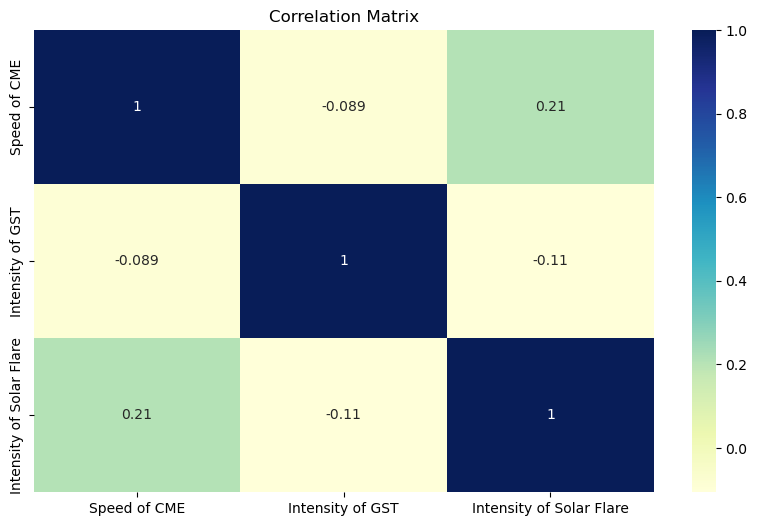

In [138]:
numeric_main_df = main_df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_main_df.corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix")
plt.show()

*Weak positive correlation between Solar flare intensity and speed of CME (0.21).
There is a very weak negative correlation between the speed of CME Solar flare intensity and GST (-0.089) and also between the Intensity of Solar Flare and CME Speed. Since the GST intensity values are imputed with the values close to the date, it is very interesting to study more on CME and GST variables or Flare Intensity with GST.*

**Time series plot of CME and GST**

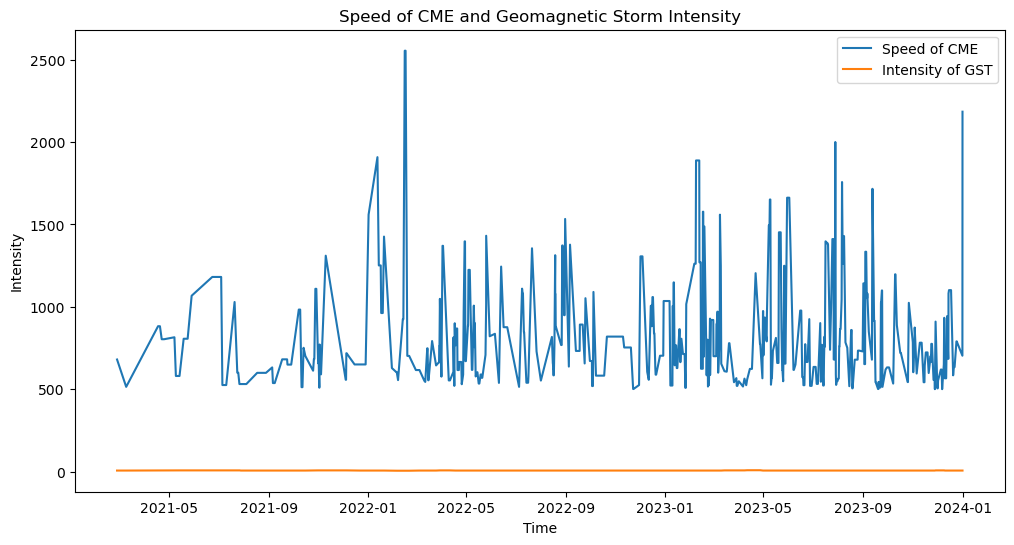

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(main_df['Time'], main_df['Speed of CME'], label='Speed of CME')
plt.plot(main_df['Time'], main_df['Intensity of GST'], label='Intensity of GST')
plt.legend()
plt.title("Speed of CME and Geomagnetic Storm Intensity")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.show()

*The high variability in CME speed and the near-flat nature of GST intensity make it challenging to understand the underlying patterns (trend) or potential relationships between these variables.*

Since the Intensity of GST data has been imputed and has a limited number of values, studying GST further might require different strategies to gain more insights while accounting for the imputation

## Advance Analysis

**Rolling averages for GST and CME**

For CME a rolling average helps to smooth the extreme fluctuations in CME speed, allowing you to observe longer-term trends and patterns rather than noise from sudden spikes. For GST, a rolling average can help reveal any subtle trends or gradual changes that might otherwise be obscured by the low variability.

In [142]:
main_df['CME Rolling'] = main_df['Intensity of Solar Flare'].rolling(window=30).mean()
main_df['GST Rolling'] = main_df['Intensity of GST'].rolling(window=3).mean()
main_df

,Time,Class Type of Solar Flare,Speed of CME,Intensity of GST,Intensity of Solar Flare,Main Flare Class,CME Rolling,GST Rolling
0,2021-02-26 07:01:00+00:00,B9.5,680.0,6.0,29.5,B,NaN,NaN
1,2021-03-09 12:17:00+00:00,C1.6,514.0,6.0,31.6,C,NaN,NaN
2,2021-04-17 16:20:00+00:00,B9.7,882.0,7.0,29.7,B,NaN,6.333333
3,2021-04-19 23:19:00+00:00,M1.1,882.0,7.0,41.1,M,NaN,6.666667
4,2021-04-22 04:10:00+00:00,C3.8,803.0,7.0,33.8,C,NaN,7.000000
...,...,...,...,...,...,...,...,...
879,2023-12-24 11:09:00+00:00,M2.9,790.0,6.0,42.9,M,40.980000,6.000000
880,2023-12-24 16:37:00+00:00,M2.6,790.0,6.0,42.6,M,41.240000,6.000000
881,2023-12-24 19:21:00+00:00,M1.1,790.0,6.0,41.1,M,41.240000,6.000000
882,2023-12-31 18:44:00+00:00,M1.0,703.0,6.0,41.0,M,41.433333,6.000000


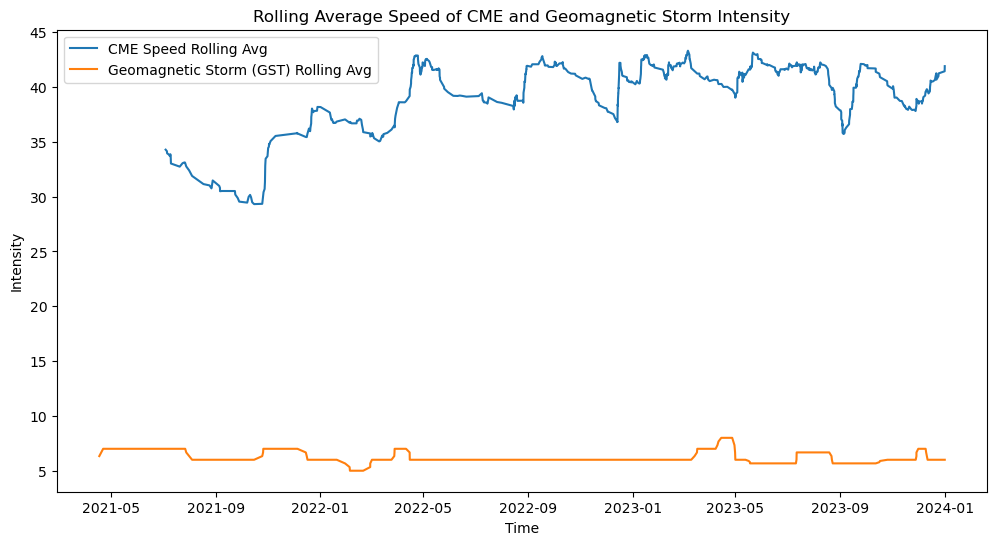

In [144]:
plt.figure(figsize=(12, 6))
plt.plot(main_df['Time'], main_df['CME Rolling'], label='CME Speed Rolling Avg')
plt.plot(main_df['Time'], main_df['GST Rolling'], label='Geomagnetic Storm (GST) Rolling Avg')
plt.legend()
plt.title("Rolling Average Speed of CME and Geomagnetic Storm Intensity")
plt.xlabel("Time")
plt.ylabel("Intensity")
plt.show()

*Compared to the fluctuating CME Speed line, the relatively stable GST line suggests that CME events alone may not have a strong immediate impact on GST Intensity. However, it may be possible that GST responds (impacts) to CME speed with a delay or that other factors influence GST beyond CME speed alone.*

**Cross-Correlation Analysis**

Cross-correlation allows us to examine if there is a delayed effect of CME Speed on GST Intensity. Since GST does not seem to respond immediately to fluctuations in CME Speed, a time-lagged relationship might exist. Cross-correlation can help pinpoint the lag period (if any) where the relationship between these variables is strongest.

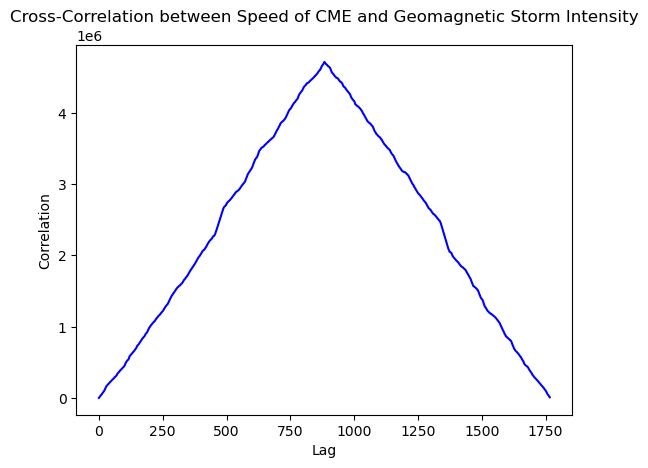

In [146]:
cross_corr = np.correlate(main_df['Speed of CME'], main_df['Intensity of GST'], mode='full')
plt.plot(cross_corr,color='b')
plt.title("Cross-Correlation between Speed of CME and Geomagnetic Storm Intensity")
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

*A strong correlation around 875 lag indicates that the Speed of the CME could influence GST intensity over certain time lags. This delayed effect may indicate that solar wind or particles ejected during CME take time to reach Earth (as the sun) and influence geomagnetic conditions, leading to changes in GST intensity.*

This delayed response is consistent with physical processes in space weather, where geomagnetic storms are affected by solar activity with a certain time delay.

## Conclusion

This analysis examined the influence of solar flares (SF) and coronal mass ejections (CME) on geomagnetic storms (GST). Correlation analysis showed a weak positive relationship between CME speed and solar flare intensity, with minimal direct correlation to GST intensity, indicating the complexity of the SF-CME-GST relationship. Rolling averages revealed that while CME speed fluctuated significantly, GST intensity remained relatively stable. Cross-correlation analysis identified a peak at a lag of approximately 875 units, suggesting that CME speed may impact GST intensity after a delay, aligning with the delayed arrival of solar particles to Earth. Limitations include the sparse and imputed GST data, which may affect accuracy, and the weak correlations observed, which suggest that other factors beyond CME speed and solar flares likely influence GST intensity.

## Works Cited

"Cross-Correlation." *Investopedia*, [https://www.investopedia.com/terms/c/crosscorrelation.asp](https://www.investopedia.com/terms/c/crosscorrelation.asp)

OpenAI. "How to Study Lag of Time: A Guide to Time-Series Analysis." *ChatGPT*, 12 Nov. 2024.

  OpenAI. (2024). ChatGPT [Large language model]. 

 pandas.merge_asof. *pandas Documentation*
https://pandas.pydata.org/docs/reference/api/pandas.merge_asof.html).
